# A Notebook showcasing the NTS-UK 2017 travel patterns and Simulated EV demand across years and seasons.

### Importing Libraries & Root folder

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import EVforecaster.config as cfg
import numpy as np

dataframes_folder = cfg.root_folder + "/dataframes/"
plots_folder = cfg.root_folder + "/plots/"


### Importing Data

In [2]:
nts_uk_2017 = pd.read_pickle(dataframes_folder + "/merge_trip_day_hh_2017.pkl")



In [3]:
nts_uk_2017.head()

,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,JourSeq,TripStart,TripEnd,...,TripOrigGOR_B02ID,TripDestGOR_B02ID,TripStartLoc,TripEndLoc,TripType,TripStartRolling,TripEndRolling,TravelYear,TravelWeekDay_B01ID,TWSWeek
0,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,1.0,2.0,1.0,540.0,580.0,...,5.0,5.0,3,2,3,1980.0,2020.0,2017,5,2
1,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,1.0,2.0,1.0,540.0,580.0,...,5.0,5.0,3,2,3,1980.0,2020.0,2017,5,2
2,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,1.0,2.0,2.0,960.0,995.0,...,5.0,5.0,2,3,4,2400.0,2435.0,2017,5,2
3,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,1.0,2.0,2.0,960.0,995.0,...,5.0,5.0,2,3,4,2400.0,2435.0,2017,5,2
4,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,1.0,5.0,1.0,600.0,620.0,...,5.0,5.0,3,2,3,6360.0,6380.0,2017,1,2


## NTS-UK 2017 travel patterns

### Exploring travel patterns over the year

In [19]:
nts_uk_2017.columns

Index(['TripID', 'DayID', 'IndividualID', 'HouseholdID', 'PSUID', 'PersNo',
       'TravDay', 'JourSeq', 'TripStart', 'TripEnd', 'TripDisExSW',
       'TripOrigGOR_B02ID', 'TripDestGOR_B02ID', 'TripStartLoc', 'TripEndLoc',
       'TripType', 'TripStartRolling', 'TripEndRolling', 'TravelYear',
       'TravelWeekDay_B01ID', 'TWSWeek'],
      dtype='object')

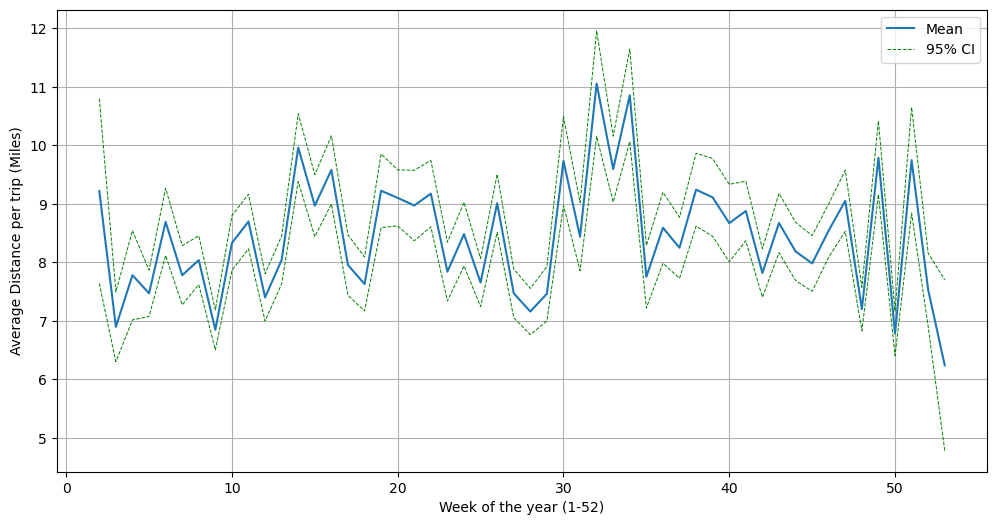

In [55]:
distance_by_week = nts_uk_2017.groupby("TWSWeek")["TripDisExSW"].agg(["mean", "std", "count"])

distance_by_week["CI"] = 1.96*distance_by_week["std"]/ np.sqrt(distance_by_week["count"])

distance_by_week["CI-"] = distance_by_week["mean"] - distance_by_week["CI"]
distance_by_week["CI+"] = distance_by_week["mean"] + distance_by_week["CI"]

x = distance_by_week.index
y = distance_by_week["mean"]
ci_plus = distance_by_week["CI+"]
ci_minus = distance_by_week["CI-"]

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(x,y, label="Mean")
plt.plot(x, ci_plus, label="95% CI" , linestyle="--", color="green", linewidth=0.7)
plt.plot(x, ci_minus, linestyle="--",                 color="green", linewidth=0.7)

plt.legend()

plt.ylabel("Average Distance per trip (Miles)")
plt.xlabel("Week of the year (1-52)")

plt.savefig(plots_folder + "/weekly_trip_distance.pdf", format="pdf")


### Exploring TripType Proportions

In [4]:
triptype_vcs = nts_uk_2017.value_counts("TripType",normalize=True)

triptype_vcs.to_frame().round(3).sort_index()

,proportion
TripType,
1,0.119
2,0.113
3,0.307
4,0.306
5,0.023
6,0.019
7,0.014
8,0.099


### Trip Type Mapping

In [5]:
trip_type_mapping = {
    
    1:   "Home-Work",
    2:   "Work-Home",

    3:   "Home-Other",
    4:   "Other-Home",

    5:   "Work-Other",
    6:   "Other-Work",

    7:   "Home-Home",
    8:   "Other-Other",
    #"3-3": 9,   #Work-Work
}

### Plotting Distributions of TripStart and TripDisExSW across different trip types.

In [6]:
def plot_dists(df, trip_type_index, variable_index, mapping=trip_type_mapping):
    ## Comparing individual trip stats

    df = df.copy()
    df = df[df.TripType == trip_type_index]

    # Plot histogram
    #plt.figure(figsize=(7, 5))
    plt.hist(df[variable_index], bins=75, alpha=0.5, label="Real", color="blue", density=True)


    if variable_index == "TripDisExSW":
        plt.xlim(0,100)

    # Labels and legend
    plt.xlabel(f"{variable_index}")
    plt.ylabel("Density")
    plt.title(f"Histogram of {variable_index} for trip type: {mapping[trip_type_index]}.")
    plt.grid()

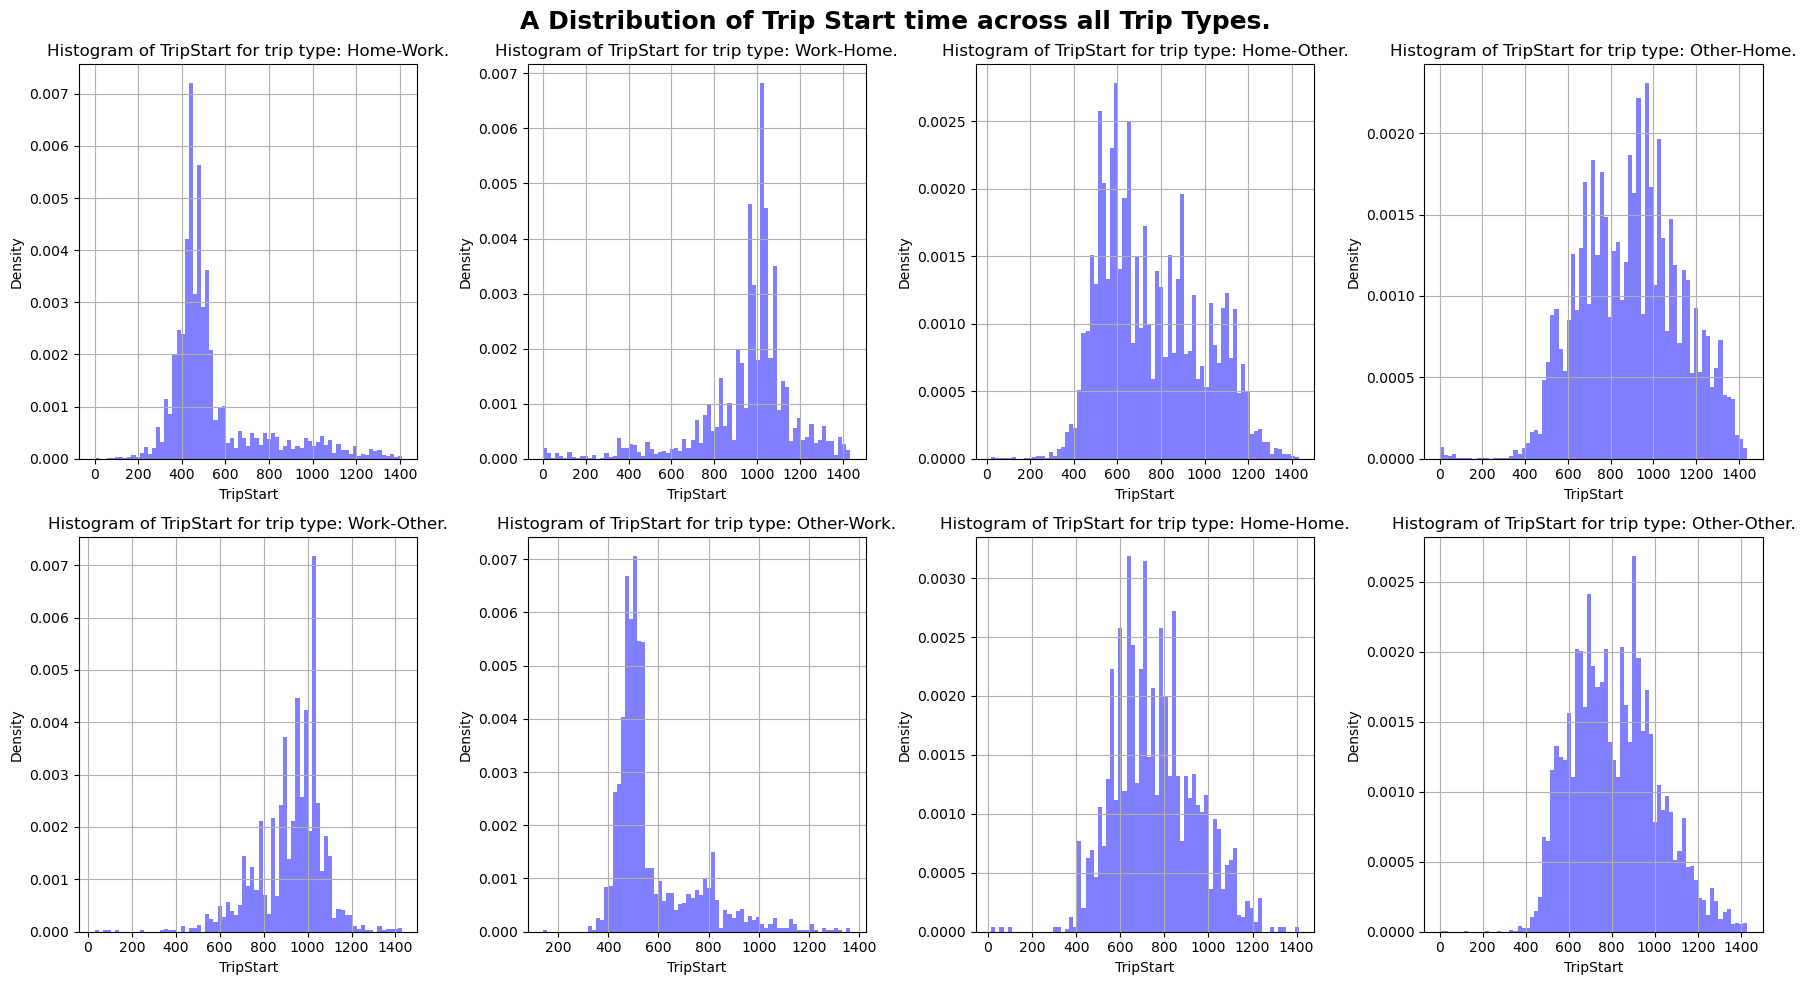

In [7]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("A Distribution of Trip Start time across all Trip Types.", fontsize=18, fontweight="bold")

for i in range(1,9):
    plt.subplot(2,4,i)
    plot_dists(df=nts_uk_2017, trip_type_index=i, variable_index="TripStart")


plt.tight_layout()  # Adjust layout to avoid overlap

plt.savefig(plots_folder + "/TripStartTripType.pdf", format="pdf", bbox_inches="tight")

plt.show()



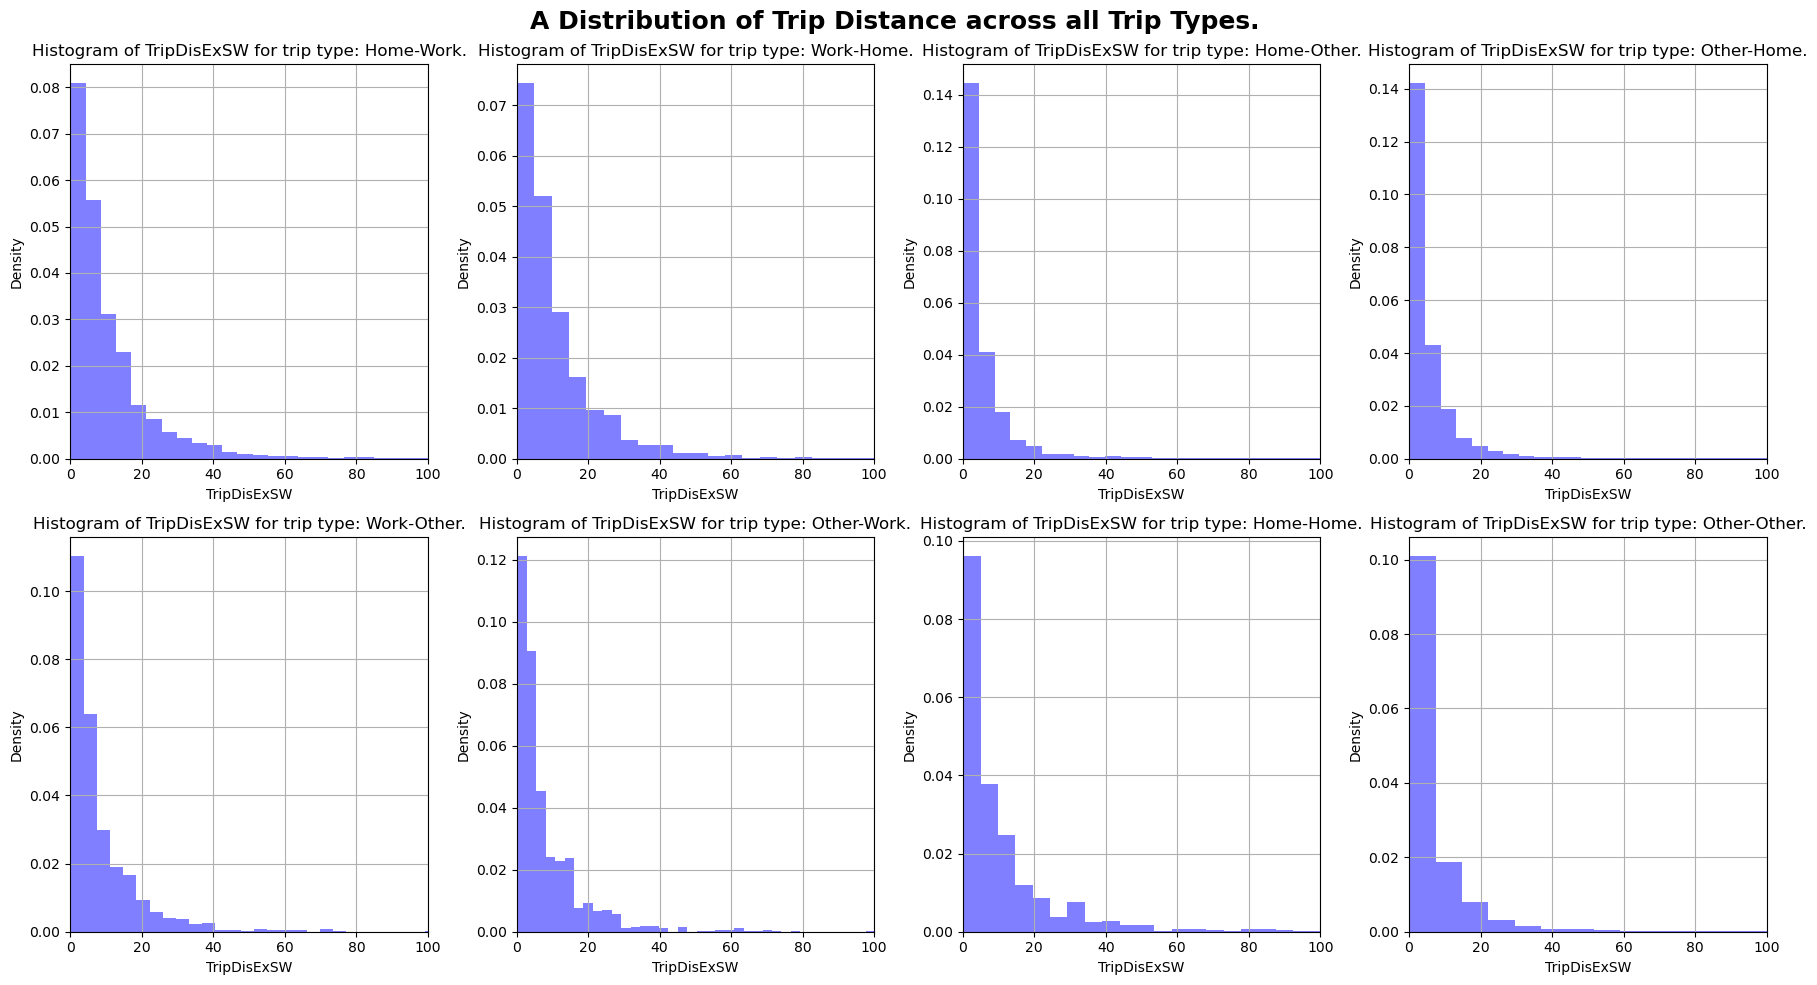

In [8]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("A Distribution of Trip Distance across all Trip Types.", fontsize=18, fontweight="bold")

for i in range(1,9):
    plt.subplot(2,4,i)
    plot_dists(df=nts_uk_2017, trip_type_index=i, variable_index="TripDisExSW")


plt.tight_layout()  # Adjust layout to avoid overlap

plt.savefig(plots_folder + "/DistanceTripType.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Simulated EV demand

In [9]:
import EVforecaster.config as cfg
from EVforecaster.demand_curves import plot_weekly_demand

In [10]:
charging_df_path = cfg.root_folder + "/dataframes/charging_df.pkl"
plots_folder = cfg.root_folder + "/plots/"
charging_df = pd.read_pickle(charging_df_path)

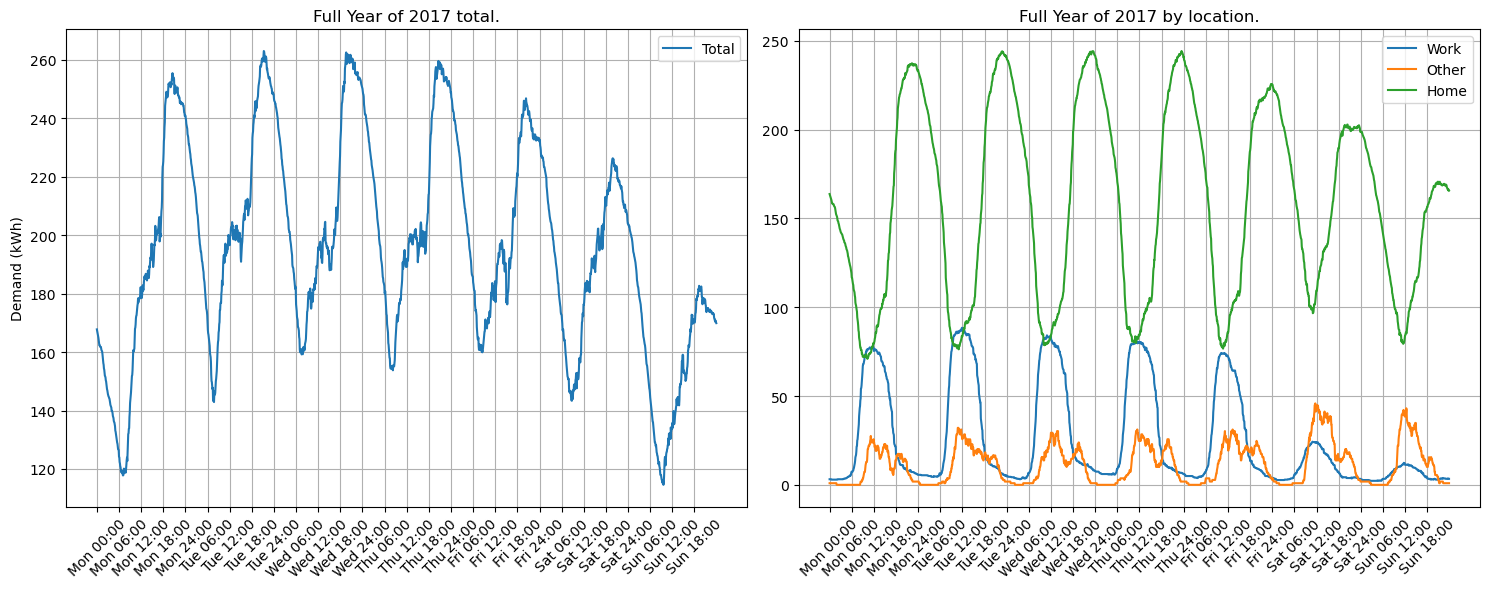

In [11]:
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_total", week_of_the_year=list(range(2,53)), week_label="Full Year", year_label=2017, save_fig=False)


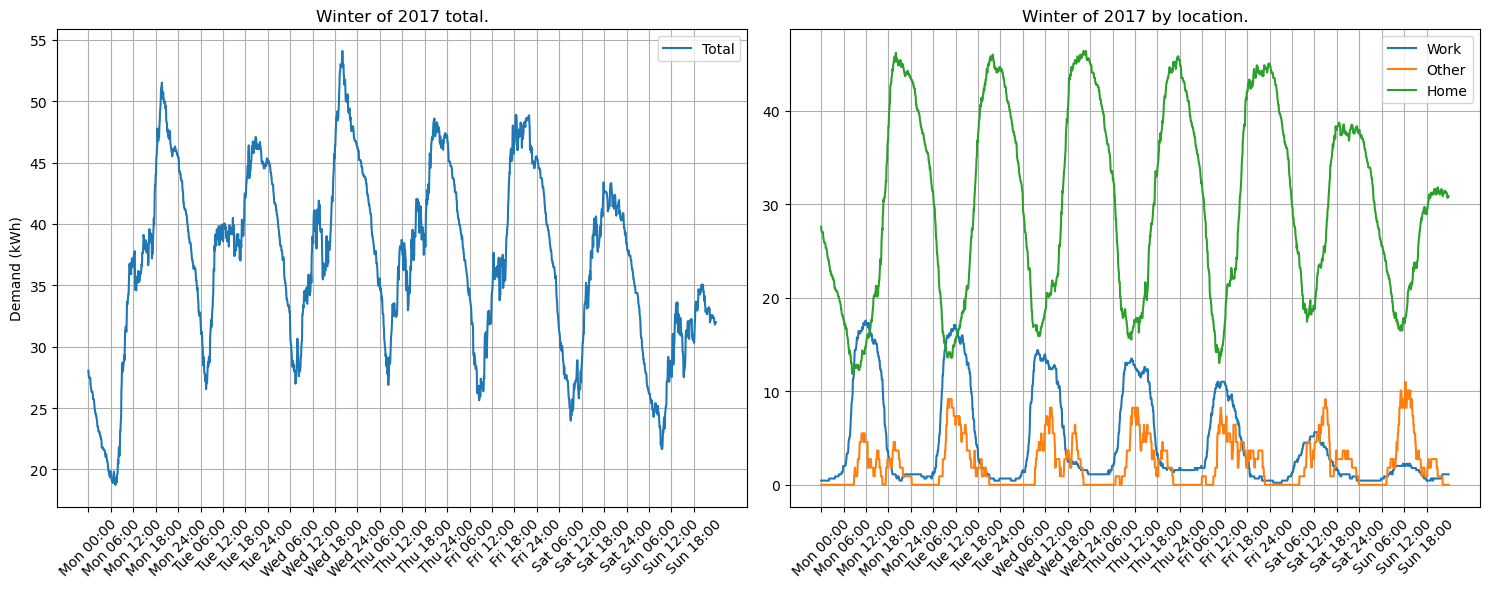

In [12]:
weeks_winter = [49,50,51,52] + list(range(1,10))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_winter", week_of_the_year=weeks_winter, week_label="Winter", year_label=2017, save_fig=False)

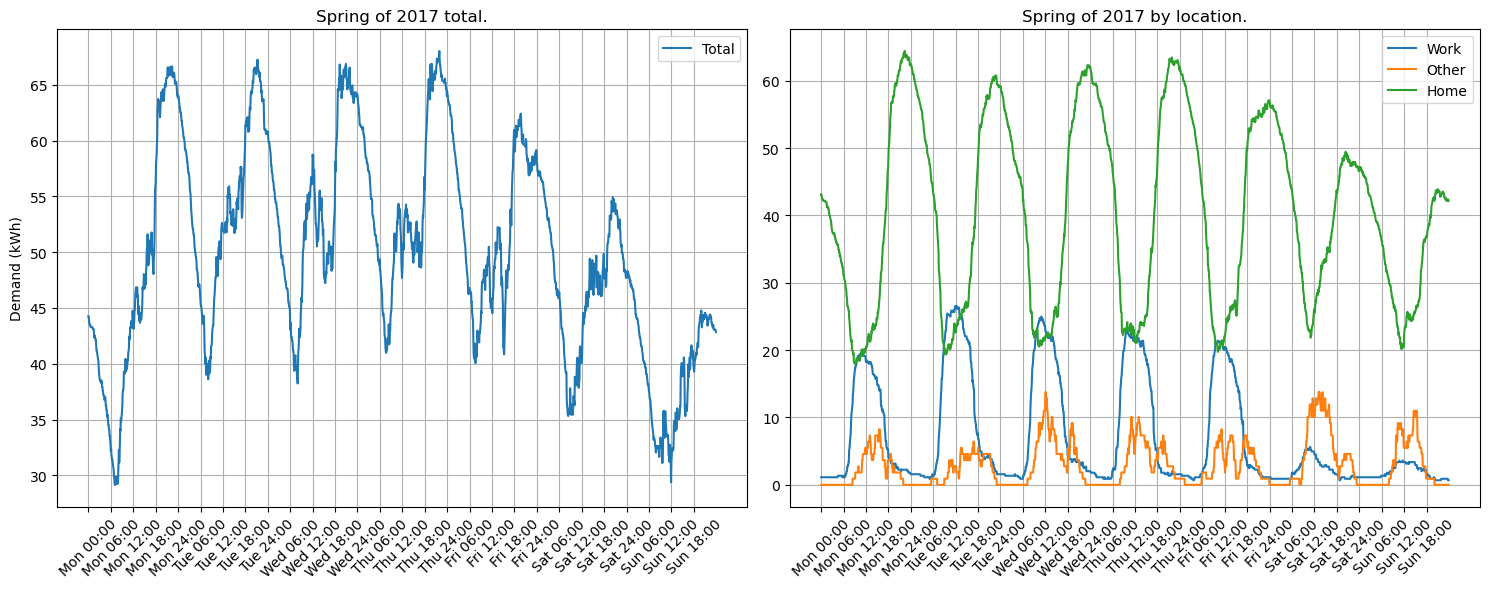

In [13]:
weeks_spring = list(range(10,22))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_spring", week_of_the_year=weeks_spring, week_label="Spring", year_label=2017, save_fig=False)

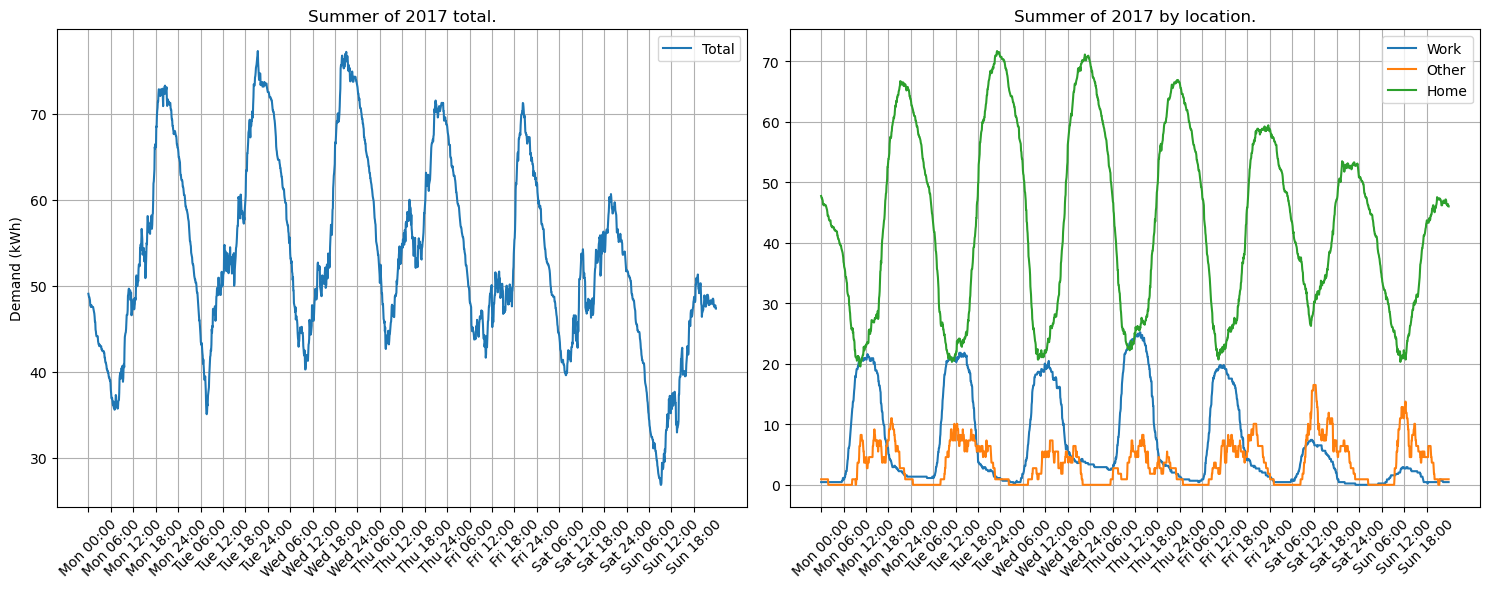

In [14]:
weeks_summer = list(range(22,36))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_summer", week_of_the_year=weeks_summer, week_label="Summer", year_label=2017, save_fig=False)

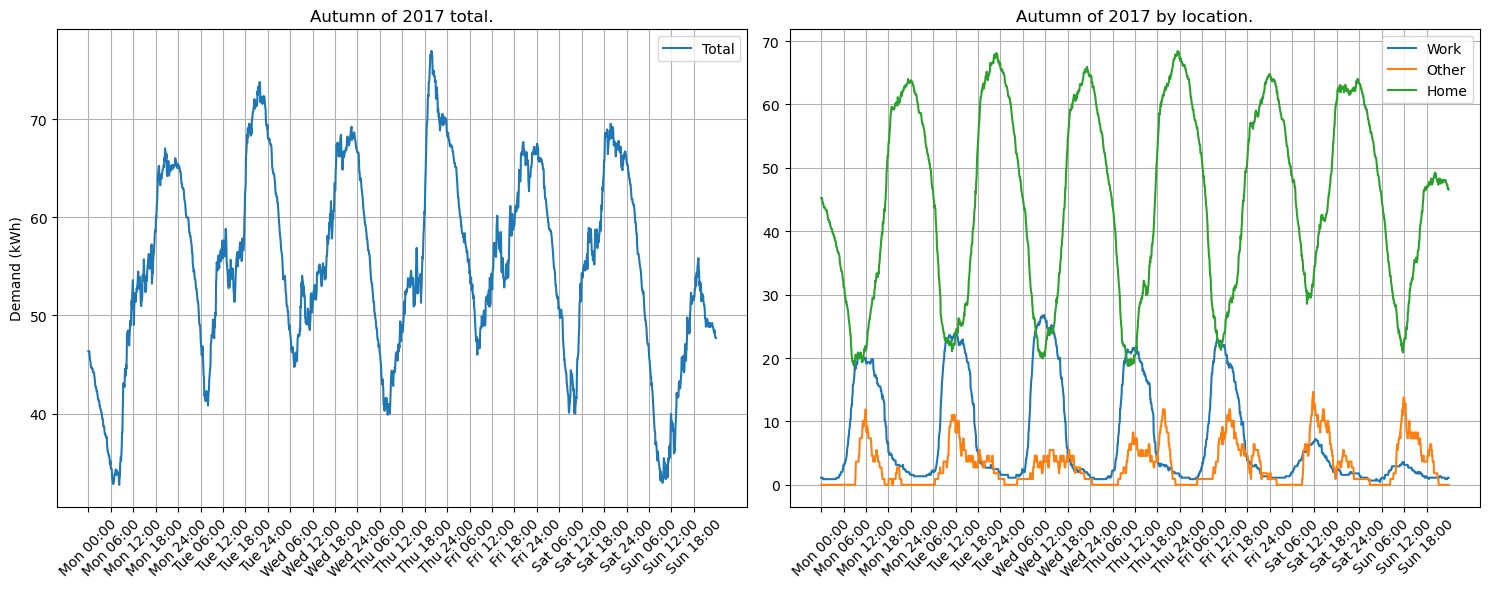

In [15]:
weeks_autumn = list(range(36,49))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_autumn", week_of_the_year=weeks_autumn, week_label="Autumn", year_label=2017, save_fig=False)